In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, 
                             davies_bouldin_score, rand_score, 
                             adjusted_rand_score)
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import shapiro
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [44]:
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['target'] = wine.target

print("ХАРАКТЕРИСТИКИ ДАТАСЕТА")
print(f"Количество образцов: {df.shape[0]}")
print(f"Количество признаков: {df.shape[1] - 1} (плюс target)")
print(f"\nТипы данных:")
print(df.dtypes.value_counts())
print(f"\nПропущенные значения:")
print(df.isnull().sum().sum())
print(f"\nБаланс классов:")
print(df['target'].value_counts())

ХАРАКТЕРИСТИКИ ДАТАСЕТА
Количество образцов: 178
Количество признаков: 13 (плюс target)

Типы данных:
float64    13
int64       1
Name: count, dtype: int64

Пропущенные значения:
0

Баланс классов:
target
1    71
0    59
2    48
Name: count, dtype: int64


In [45]:
print("СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ")
print(df.describe().round(2))

СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ
       alcohol  malic_acid     ash  alcalinity_of_ash  magnesium  \
count   178.00      178.00  178.00             178.00     178.00   
mean     13.00        2.34    2.37              19.49      99.74   
std       0.81        1.12    0.27               3.34      14.28   
min      11.03        0.74    1.36              10.60      70.00   
25%      12.36        1.60    2.21              17.20      88.00   
50%      13.05        1.87    2.36              19.50      98.00   
75%      13.68        3.08    2.56              21.50     107.00   
max      14.83        5.80    3.23              30.00     162.00   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count         178.00      178.00                178.00           178.00   
mean            2.30        2.03                  0.36             1.59   
std             0.63        1.00                  0.12             0.57   
min             0.98        0.34                  0.13   

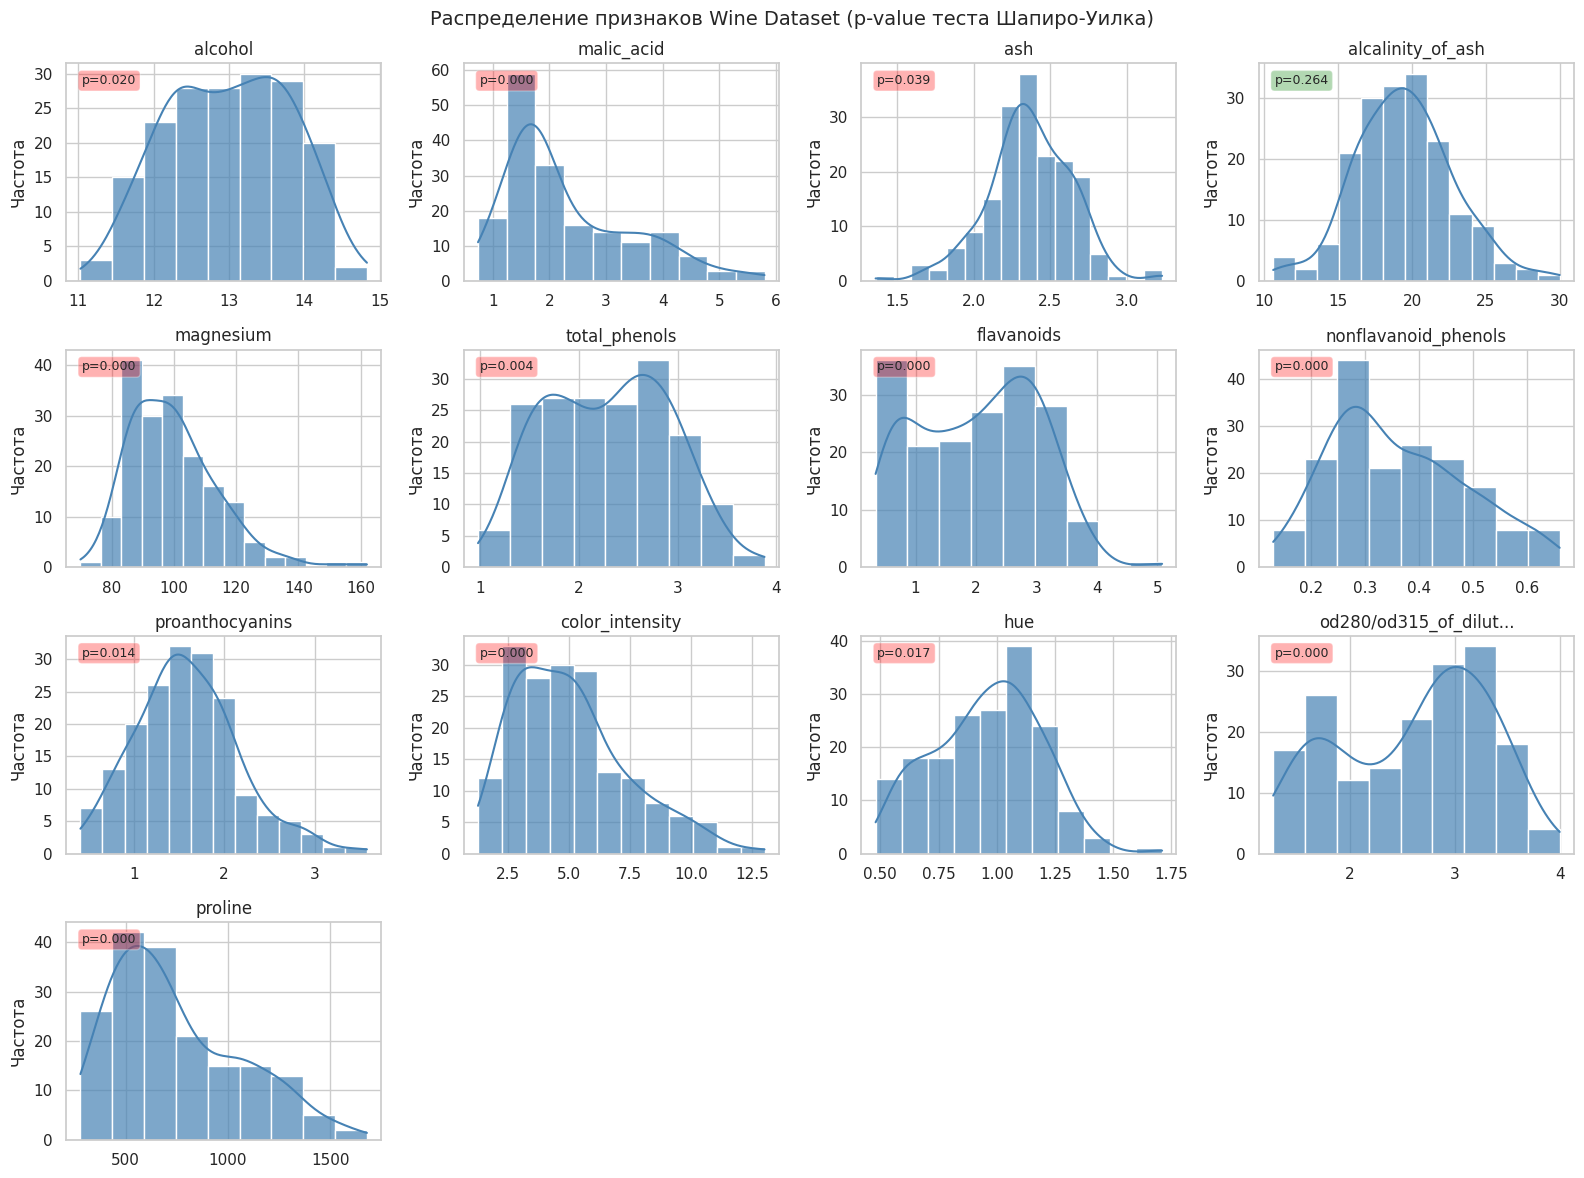

In [46]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
features = wine.feature_names

for idx, feature in enumerate(features):
    row, col = idx // 4, idx % 4
    ax = axes[row, col]
    
    sns.histplot(df[feature], kde=True, ax=ax, color='steelblue', alpha=0.7)
    ax.set_title(f'{feature[:20]}...' if len(feature) > 20 else feature)
    ax.set_xlabel('')
    ax.set_ylabel('Частота')
    
    stat, p_value = shapiro(df[feature])
    color = 'green' if p_value > 0.05 else 'red'
    ax.text(0.05, 0.95, f'p={p_value:.3f}', transform=ax.transAxes, 
            fontsize=9, verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))

for idx in range(len(features), 16):
    row, col = idx // 4, idx % 4
    fig.delaxes(axes[row, col])

plt.suptitle('Распределение признаков Wine Dataset (p-value теста Шапиро-Уилка)', 
             fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

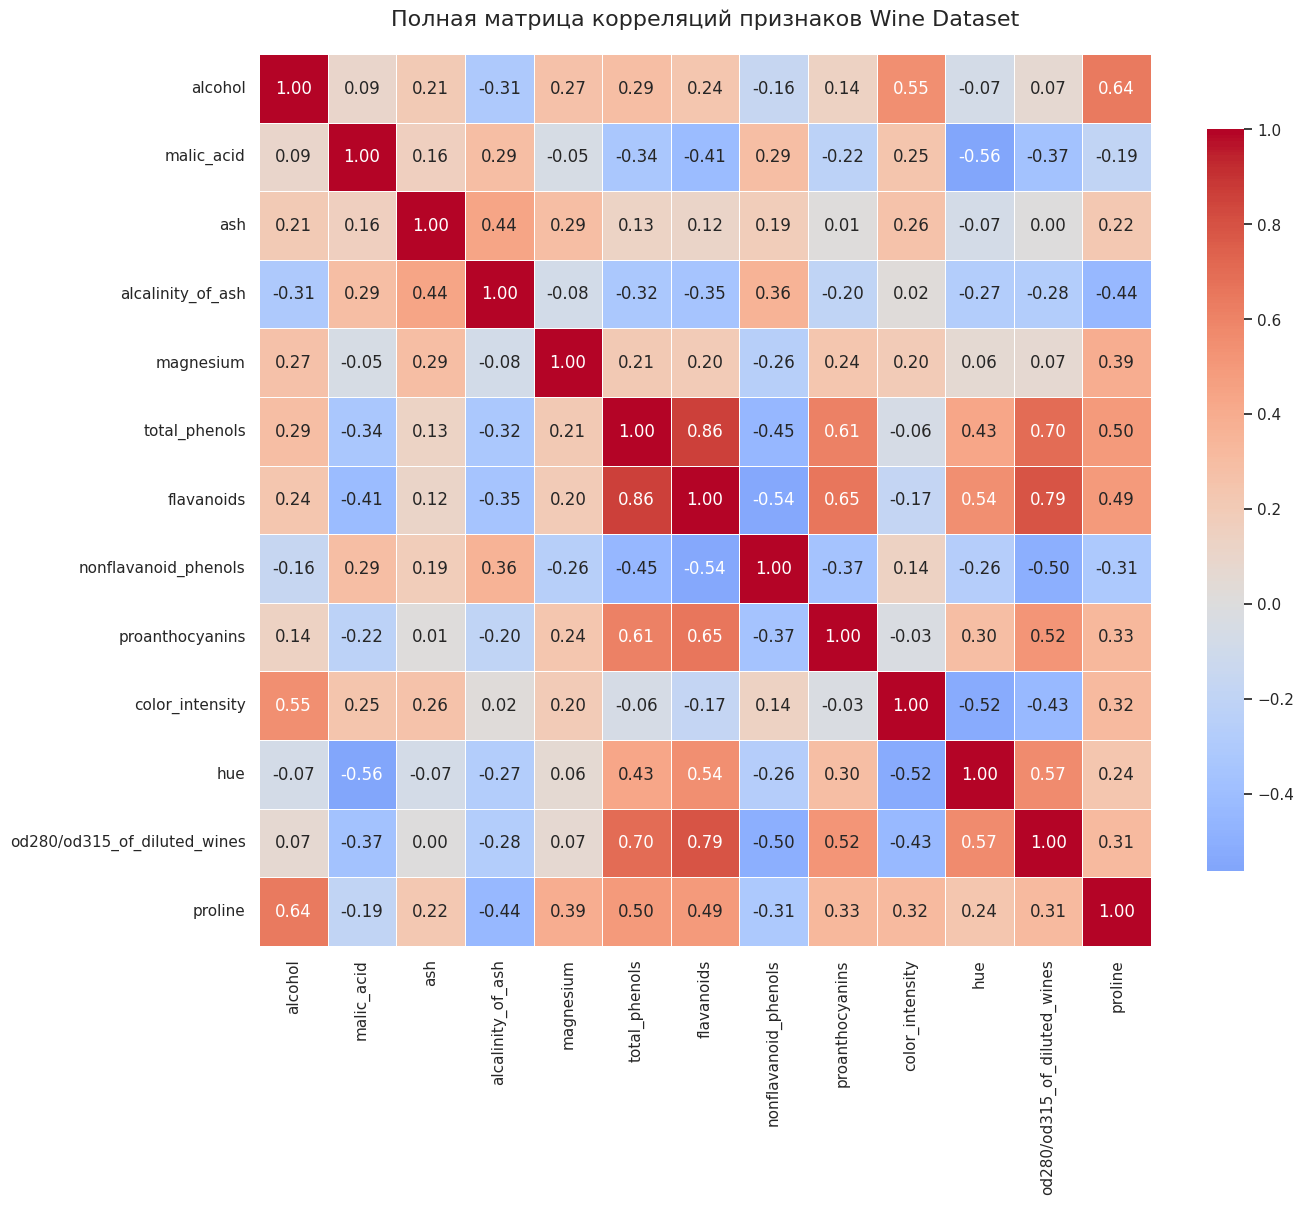

In [47]:
plt.figure(figsize=(14, 12))
corr_matrix = df[wine.feature_names].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, 
            cbar_kws={"shrink": 0.8})

plt.title('Полная матрица корреляций признаков Wine Dataset', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

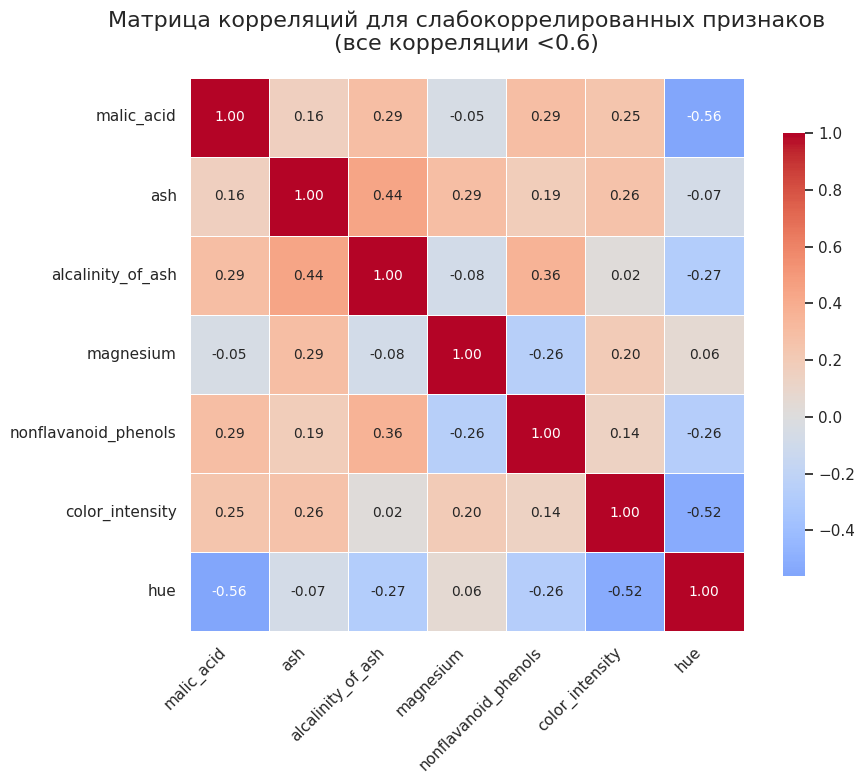

In [91]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_filtered, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            annot_kws={"size": 10})

plt.title('Матрица корреляций для слабокоррелированных признаков\n(все корреляции <0.6)', 
          fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [94]:
# Абсолютная корреляция
corr_matrix = df[wine.feature_names].corr().abs()

upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [
    column for column in upper_triangle.columns
    if any(upper_triangle[column] > 0.6)
]

print("Удалённые признаки:", to_drop)

# Датафрейм без сильнокоррелированных признаков
df_filtered = df.drop(columns=to_drop)

# <<< ВАЖНО: список признаков >>>
filtered_features = [
    col for col in df_filtered.columns if col != 'target'
]

print("Используемые признаки:", filtered_features)


Удалённые признаки: ['flavanoids', 'proanthocyanins', 'od280/od315_of_diluted_wines', 'proline']
Используемые признаки: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'nonflavanoid_phenols', 'color_intensity', 'hue', 'KMeans_cluster']


In [95]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered[filtered_features])

print("Данные стандартизированы корректно")
print("Среднее:", X_scaled.mean(axis=0)[:5])
print("Std:", X_scaled.std(axis=0)[:5])

Данные стандартизированы корректно
Среднее: [-8.38280756e-16 -1.19754394e-16 -8.37033314e-16 -3.99181312e-17
 -3.99181312e-17]
Std: [1. 1. 1. 1. 1.]


✅ ДАННЫЕ ОБНОВЛЕНЫ С УЧЕТОМ ОТОБРАННЫХ ПРИЗНАКОВ
Исходная размерность: (178, 13)
Новая размерность: (178, 7)

Слабокоррелированные признаки: malic_acid, ash, alcalinity_of_ash, magnesium, nonflavanoid_phenols, color_intensity, hue


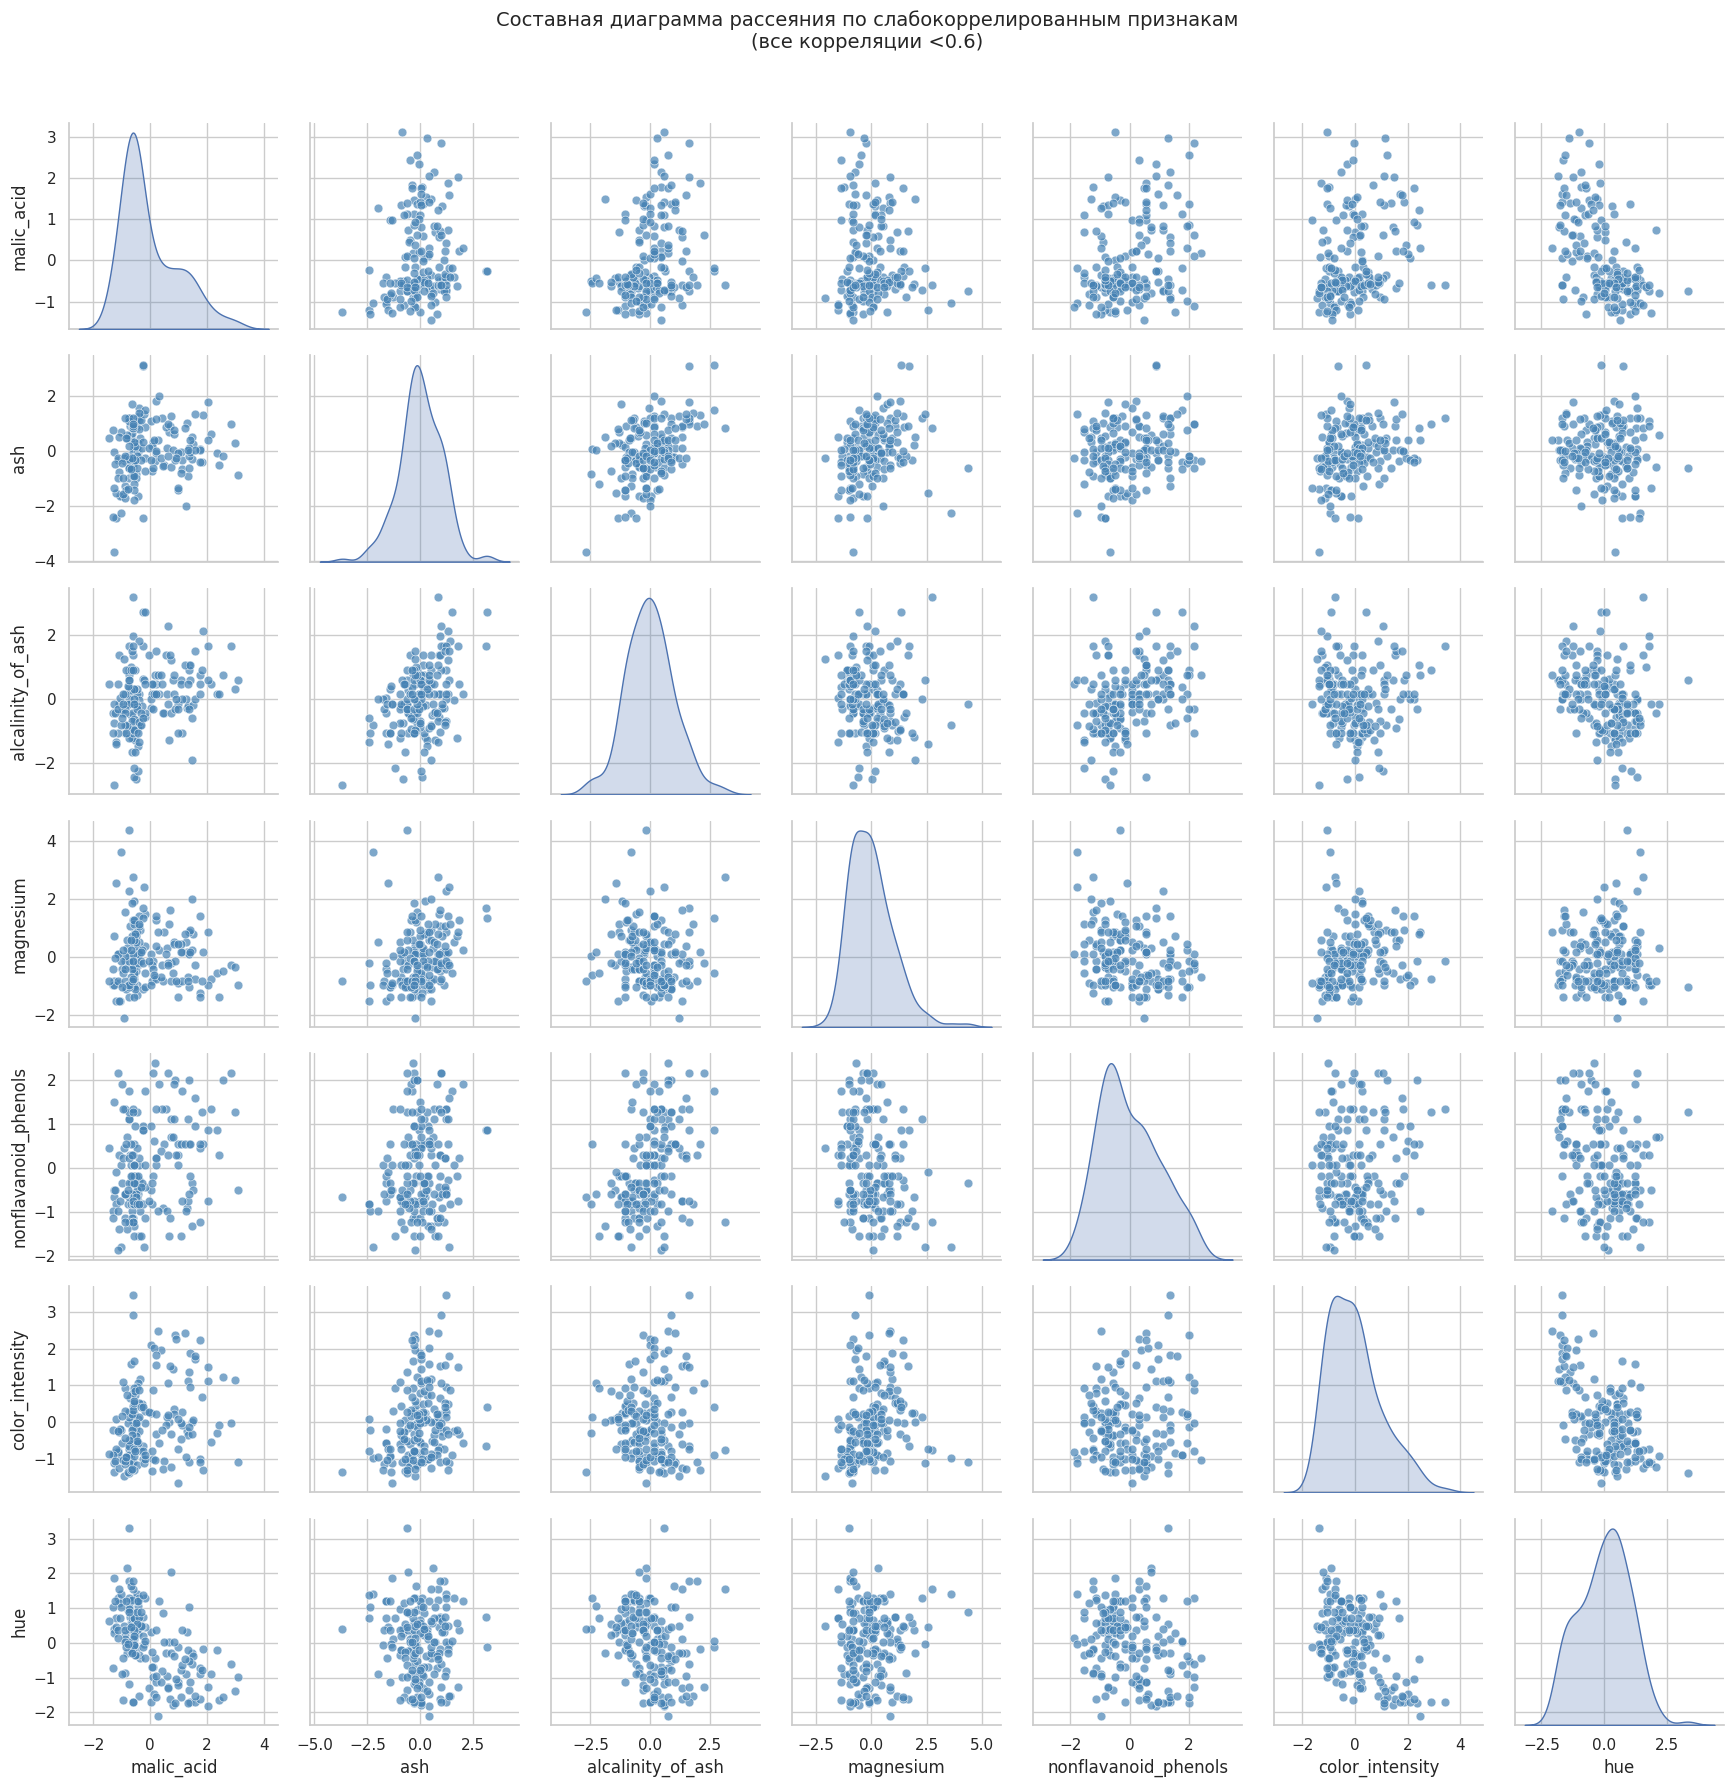


📊 СТАТИСТИКА ОСТАВШИХСЯ ПРИЗНАКОВ:
malic_acid:
  Среднее: 2.34
  Стандартное отклонение: 1.12
  Минимум: 0.74
  Максимум: 5.80

ash:
  Среднее: 2.37
  Стандартное отклонение: 0.27
  Минимум: 1.36
  Максимум: 3.23

alcalinity_of_ash:
  Среднее: 19.49
  Стандартное отклонение: 3.34
  Минимум: 10.60
  Максимум: 30.00

magnesium:
  Среднее: 99.74
  Стандартное отклонение: 14.28
  Минимум: 70.00
  Максимум: 162.00

nonflavanoid_phenols:
  Среднее: 0.36
  Стандартное отклонение: 0.12
  Минимум: 0.13
  Максимум: 0.66

color_intensity:
  Среднее: 5.06
  Стандартное отклонение: 2.32
  Минимум: 1.28
  Максимум: 13.00

hue:
  Среднее: 0.96
  Стандартное отклонение: 0.23
  Минимум: 0.48
  Максимум: 1.71



In [96]:
if low_corr_features:
    # Создаем новые наборы данных с отобранными признаками
    X_filtered = df[low_corr_features]
    X_scaled_filtered = scaler.fit_transform(X_filtered)
    
    print("✅ ДАННЫЕ ОБНОВЛЕНЫ С УЧЕТОМ ОТОБРАННЫХ ПРИЗНАКОВ")
    print(f"Исходная размерность: {X.shape}")
    print(f"Новая размерность: {X_filtered.shape}")
    print(f"\nСлабокоррелированные признаки: {', '.join(low_corr_features)}")
    
    # Сохраняем отфильтрованные данные для дальнейшего использования
    X_scaled_original = X_scaled  # Сохраняем оригинальные стандартизованные данные
    X_scaled = X_scaled_filtered  # Теперь работаем с отфильтрованными данными
else:
    print("⚠️  Не удалось отобрать слабокоррелированные признаки")
    print("Используем все исходные признаки")
    
if low_corr_features:
    # Создаем DataFrame из стандартизованных отфильтрованных данных
    X_scaled_filtered_df = pd.DataFrame(X_scaled_filtered, columns=low_corr_features)
    
    # Построение матрицы диаграмм рассеивания
    sns.pairplot(
        X_scaled_filtered_df,
        diag_kind="kde",
        plot_kws={"alpha": 0.7, "s": 40, "color": "steelblue"}
    )
    
    plt.suptitle(
        "Составная диаграмма рассеяния по слабокоррелированным признакам\n(все корреляции <0.6)",
        y=1.02,
        fontsize=14
    )
    plt.tight_layout()
    plt.show()
    
    # Анализ оставшихся признаков
    print("\n📊 СТАТИСТИКА ОСТАВШИХСЯ ПРИЗНАКОВ:")
    print("=" * 50)
    for feature in low_corr_features:
        feature_data = df[feature]
        print(f"{feature}:")
        print(f"  Среднее: {feature_data.mean():.2f}")
        print(f"  Стандартное отклонение: {feature_data.std():.2f}")
        print(f"  Минимум: {feature_data.min():.2f}")
        print(f"  Максимум: {feature_data.max():.2f}")
        print()
else:
    print("Невозможно построить матрицу рассеивания - нет отобранных признаков")